In [73]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from trade_flow_modelling.src.data_management.sign_extractor import sign_extractor
from trade_flow_modelling.src.modelisation.time_series_models import autoregressive_model
from trade_flow_modelling.src.data_management.data_loader.data_loader import load_data
import pyspark.sql.functions as F

from statsmodels.tsa.tsatools import lagmat
import statsmodels.api as sm
from statsmodels.tools.tools import pinv_extended
from scipy.optimize import minimize_scalar, milp, brute, minimize
from trade_flow_modelling.src.modelisation.regression import linear_models
from typing import Literal

folder_path_key_to_nb_lags_and_time = "/Users/martingangand/Documents/trade_flow_modelling/trade_flow_modelling/src/notebooks/key_to_nb_lags_info"
versions = ["statsmodels", "opti", "multi_processes", "scipy_opti_minimize_scalar", "scipy_opti_minimize", "mystic_opti", "perso_opti"]
version_to_file_name = {version: f"key_to_nb_lags_info_{version}.npy" for version in versions}

symbols = ["SOLUSDT", "DOGEUSDT", "DOTUSDT", "BCHUSDT", "ETCUSDT", "XLMUSDT", "HBARUSDT"]
dates_jan = [f"2024-01-{i}" for i in range(1, 32)]

def computeKey(date, symbol):
    date_split = date.split("-")
    # assert(len(date_split) == 3)
    if (len(date_split[-1]) == 1):
        date_split[-1] = f"0{date_split[-1]}"
    date = "".join(date_split)

    return f"{date} {symbol}"

def saveDictionary(dictionary, file_path, allow_pickle=True):
    np.save(file_path, dictionary, allow_pickle=allow_pickle)

def loadDictionary(file_path, allow_pickle=True):
    dictionary = np.load(file_path, allow_pickle=allow_pickle).item()
    return dictionary

In [35]:
def computeAvgNbTradesPerDay(data):
    mean_median = data.groupBy(F.col("date")).agg(F.count(F.col("time")).alias("nb_trades")).select(F.mean(F.col("nb_trades")), F.median(F.col("nb_trades"))).collect()
    return round(mean_median[0][0]), round(mean_median[0][1])

start_date = dates_jan[0]
end_date = dates_jan[-1]
s = "\n"
print(f"Average number of trades per day for {len(symbols)} symbols for {len(dates_jan)} dates from {start_date} to {end_date}")
for symbol in symbols:
    data = load_data(symbol, "daily", start_date, end_date)
    mean, median = computeAvgNbTradesPerDay(data)
    s += f"    {symbol}: mean: {mean} | med: {median}\n"
print(s)

Average number of trades per day for 8 symbols for 31 dates from 2024-01-1 to 2024-01-31



    SOLUSDT: mean: 736525 | med: 708563
    DOGEUSDT: mean: 165640 | med: 144162
    DOTUSDT: mean: 137198 | med: 107791
    BCHUSDT: mean: 56660 | med: 43921
    ETCUSDT: mean: 121301 | med: 77914
    NEARUSDT: mean: 163204 | med: 128251
    XLMUSDT: mean: 28144 | med: 23648
    HBARUSDT: mean: 41730 | med: 38224



In [71]:
# Compute nb_lags, time taken and nb_signs for a given version

def computeNbLagsInfo(dates, symbols, version: Literal["statsmodels", "opti", "multi_processes", "scipy_opti_minimize_scalar", "scipy_opti_minimize", "mystic_opti", "perso_opti"], nb_signs_max=None, save=False, verbose=False):
    s = time.time()
    assert(version in version_to_file_name)

    if (verbose):
        print(f"{'*' * 25} START {version} {'*' * 25}")
        print(f"{len(dates)} dates and {len(symbols)} symbols")
    key_to_nb_lags_info = {}
    for i, symbol in enumerate(symbols):
        if (verbose):
            print(f"    {symbol} ({i + 1}/{len(symbols)})")
            print(f"    0 %", end="")
        for j, date in enumerate(dates):
            signs = sign_extractor.retrieve_signs(symbol, date, date)
            if (nb_signs_max is not None):
                signs = signs[:nb_signs_max]
            ar_model = autoregressive_model.AutoregressiveModel(signs, nb_lags=None)
            s = time.time()
            nb_lags = ar_model.select_model_nb_lags(version, nb_processes=4)
            e = time.time()

            key = computeKey(date, symbol)
            key_to_nb_lags_info[key] = (nb_lags, e - s, len(signs)) # (nb_lags, time, nb_signs)
            if (verbose):
                percentage = round(100 * (j + 1) / len(dates))
                print(f" => {percentage} %", end="" if percentage != 100 else f"\n\n")
    assert(len(key_to_nb_lags_info) == len(dates) * len(symbols))
    e = time.time()
                
    if (save):
        file_path = f"{folder_path_key_to_nb_lags_and_time}/{dates[0]}_{dates[-1]}_{len(dates)}_{len(symbols)}_{version_to_file_name[version]}"
        saveDictionary(key_to_nb_lags_info, file_path, allow_pickle=True)
        if (verbose):
            print(f"Saved nb_lags info for version {version} in {file_path}")

    if (verbose):
        print(f"End {version} for {len(dates)} dates and {len(symbols)} symbols")
        print(f"{'*' * 20} END (time: {round(e - s, 2)} s) {'*' * 20}\n")
        
    return key_to_nb_lags_info

In [72]:
# Compute nb_lags info for different version with several dates and symbols

nb_success = 0
for version in versions:
    try:
        key_to_nb_lags_info = computeNbLagsInfo(dates_jan, symbols, version, nb_signs_max=250000, save=True, verbose=True)
        nb_success += 1
    except:
        print(f"\n!!! Problem happened for version {version} !!!")
    finally:
        if (version != versions[-1]):
            time.sleep(60)

print(f"SUMMARY: {nb_success}/{len(versions)} success")

************************* START statsmodels *************************
3 dates and 3 symbols
    ETCUSDT (1/3)
    0 % => 33 % => 67 % => 100 %

    XLMUSDT (2/3)
    0 % => 33 % => 67 % => 100 %

    HBARUSDT (3/3)
    0 % => 33 % => 67 % => 100 %

Saved nb_lags info for version statsmodels in /Users/martingangand/Documents/trade_flow_modelling/trade_flow_modelling/src/notebooks/key_to_nb_lags_info/2024-01-1_2024-01-3_3_3_key_to_nb_lags_info_statsmodels.npy
End statsmodels for 3 dates and 3 symbols
******************** END (time: 40.73 s) ********************

************************* START opti *************************
3 dates and 3 symbols
    ETCUSDT (1/3)
    0 % => 33 % => 67 % => 100 %

    XLMUSDT (2/3)
    0 % => 33 % => 67 % => 100 %

    HBARUSDT (3/3)
    0 % => 33 % => 67 % => 100 %

Saved nb_lags info for version opti in /Users/martingangand/Documents/trade_flow_modelling/trade_flow_modelling/src/notebooks/key_to_nb_lags_info/2024-01-1_2024-01-3_3_3_key_to_nb_lags_info_o

In [5]:
def retrieve_nb_lags_info_from_dic(dic, date, symbol, info_to_retrieve: Literal["nb_lags", "time", "nb_signs"]):
    info_to_idx = {"nb_lags": 0, "time": 1, "nb_signs": 2}
    assert(info_to_retrieve in info_to_idx)

    key = computeKey(date, symbol)
    if (not key in dic):
        print(f"No date found for {date} {symbol}")
    else:
        element_idx = info_to_idx[info_to_retrieve]
        return dic.get(key)[element_idx]
    
def retrieve_dates_symbols(dic_1, dic_2):
    assert(len(dic_1) == len(dic_2))

    dates = set()
    symbols = set()
    for key in dic_1.keys():
        assert(key in dic_2)
        date, symbol = key.split(" ")
        dates.add(date)
        symbols.add(symbol)

    assert(len(dic_1) == len(dates) * len(symbols))
    return sorted(list(dates)), list(symbols)


In [6]:
def compare_ar_selection_versions(dic_1, dic_2):
    dates, symbols = retrieve_dates_symbols(dic_1, dic_2)
    global_count_nb_lags_correct = 0
    abs_diff_nb_lags_when_incorrect = []
    diff_nb_lags_when_incorrect = []
    symbol_to_count_nb_lags_correct = {}
    ref_nb_lags_list = []
    other_nb_lags_list = []
    symbol_to_abs_diff_nb_lags_when_incorrect = {}
    symbol_to_diff_nb_lags_when_incorrect = {}
    symbol_to_nb_signs_per_day = {}
    total_time_ref = 0
    total_time_other = 0
    symbol_to_total_time = {}
    ref_time_list = []
    other_time_list = []

    for symbol in symbols:
        symbol_to_count_nb_lags_correct[symbol] = 0
        symbol_to_nb_signs_per_day[symbol] = []
        symbol_to_abs_diff_nb_lags_when_incorrect[symbol] = []
        symbol_to_diff_nb_lags_when_incorrect[symbol] = []
        symbol_to_total_time[symbol] = [0, 0] # [ref_time, other_time]
        for date in dates:
            key = computeKey(date, symbol)
            assert(key in dic_1 and key in dic_2)

            ref_nb_lags = retrieve_nb_lags_info_from_dic(dic_1, date, symbol, "nb_lags")
            other_nb_lags = retrieve_nb_lags_info_from_dic(dic_2, date, symbol, "nb_lags")
            global_count_nb_lags_correct += 1 if ref_nb_lags == other_nb_lags else 0
            symbol_to_count_nb_lags_correct[symbol] += 1 if ref_nb_lags == other_nb_lags else 0
            abs_diff_nb_lags_when_incorrect += [np.abs(ref_nb_lags - other_nb_lags)] if ref_nb_lags != other_nb_lags else []
            diff_nb_lags_when_incorrect += [ref_nb_lags - other_nb_lags] if ref_nb_lags != other_nb_lags else []
            symbol_to_abs_diff_nb_lags_when_incorrect[symbol] += [np.abs(ref_nb_lags - other_nb_lags)] if ref_nb_lags != other_nb_lags else []
            symbol_to_diff_nb_lags_when_incorrect[symbol] += [ref_nb_lags - other_nb_lags] if ref_nb_lags != other_nb_lags else []

            ref_nb_signs = retrieve_nb_lags_info_from_dic(dic_1, date, symbol, "nb_signs")
            other_nb_signs = retrieve_nb_lags_info_from_dic(dic_2, date, symbol, "nb_signs")
            assert(ref_nb_signs == other_nb_signs)
            symbol_to_nb_signs_per_day[symbol].append(ref_nb_signs)

            ref_time = retrieve_nb_lags_info_from_dic(dic_1, date, symbol, "time")
            other_time = retrieve_nb_lags_info_from_dic(dic_2, date, symbol, "time")
            total_time_ref += ref_time
            total_time_other += other_time
            symbol_to_total_time[symbol][0] += ref_time
            symbol_to_total_time[symbol][1] += other_time

    position_correct_nb_lags = []
    for i, symbol in enumerate(symbols):
        for j, date in enumerate(dates):
            ref_nb_lags = retrieve_nb_lags_info_from_dic(dic_1, date, symbol, "nb_lags")
            other_nb_lags = retrieve_nb_lags_info_from_dic(dic_2, date, symbol, "nb_lags")
            ref_nb_lags_list.append(ref_nb_lags)
            other_nb_lags_list.append(other_nb_lags)
            if (ref_nb_lags == other_nb_lags):
                position_correct_nb_lags.append(i * (len(dates)) + j)

            ref_time = retrieve_nb_lags_info_from_dic(dic_1, date, symbol, "time")
            other_time = retrieve_nb_lags_info_from_dic(dic_2, date, symbol, "time")
            ref_time_list.append(ref_time)
            other_time_list.append(other_time)


    global_percentage_nb_lags_correct = 100 * global_count_nb_lags_correct / (len(dic_1))
    print(f"{'*' * 25} Analysis of version 1 vs version 2 {'*' * 25}")
    print(f"{'*' * 15} A. COMPARISON OF: nb_lags {'*' * 15}")
    print(f"1. Global percentage of correct nb_lags for version 2: {round(global_percentage_nb_lags_correct, 2)} % ({global_count_nb_lags_correct}/{len(dic_1)}) (detail per symbol below)")
    for symbol in symbols:
        percentage_nb_lags_correct = 100 * symbol_to_count_nb_lags_correct[symbol] / len(dates)
        print(f"    {symbol}: {round(percentage_nb_lags_correct, 2)} % ({symbol_to_count_nb_lags_correct[symbol]}/{len(dates)}) (avg nb_signs: {round(np.mean(symbol_to_nb_signs_per_day[symbol]))} | med nb_signs: {round(np.median(symbol_to_nb_signs_per_day[symbol]))})")

    print(f"\n2. Plot version 1 nb_lags vs version 2 nb_lags")
    fig, axe = plt.subplots(1, 1, figsize=(6.5, 4))
    axe.plot(ref_nb_lags_list, color="green", label="Version 1 nb_lags", marker="o")
    axe.plot(other_nb_lags_list, color="orange", label="Version 2 nb_lags", marker="o")
    for i, position_correct in enumerate(position_correct_nb_lags):
        axe.plot(position_correct, ref_nb_lags_list[position_correct], color="purple", label="Correct nb_lags" if i == 0 else None, marker = 'x')
    for i in range(len(symbols) - 1):
        axe.axvline(x=len(dates) - 1, color='grey', label="Symbol change" if i == 0 else None, linestyle='--')
    axe.set_title("Version 1 nb_lags (green) vs version 2 nb_lags (orange) per key")
    axe.set_xlabel("Key")
    axe.set_ylabel("nb_lags")
    axe.legend()
    plt.show()

    print(f"\n3. Average difference of nb_lags when incorrect: {round(np.mean(abs_diff_nb_lags_when_incorrect), 2) if len(abs_diff_nb_lags_when_incorrect) > 0 else 0} (abs) | {round(np.mean(diff_nb_lags_when_incorrect), 2) if len(diff_nb_lags_when_incorrect) > 0 else 0} (signed) (detail per symbol below)")
    for symbol in symbols:
        avg_abs_diff_nb_lags_when_incorrect = np.mean(symbol_to_abs_diff_nb_lags_when_incorrect[symbol]) if len(symbol_to_abs_diff_nb_lags_when_incorrect[symbol]) > 0 else 0
        avg_diff_nb_lags_when_incorrect = np.mean(symbol_to_diff_nb_lags_when_incorrect[symbol]) if len(symbol_to_diff_nb_lags_when_incorrect[symbol]) > 0 else 0
        print(f"    {symbol}: {round(avg_abs_diff_nb_lags_when_incorrect, 2)} (abs) | {round(avg_diff_nb_lags_when_incorrect, 2)} (signed)")

    print(f"\n\n{'*' * 15} B. COMPARISON OF: time {'*' * 15}")
    total_percentage_diff_time = 100 * ((total_time_other / total_time_ref) - 1)
    print(f"4. Total ref time: {round(total_time_ref, 2)} s | total other time: {round(total_time_other, 2)} s ({'+' if total_percentage_diff_time > 0 else '-'}{round(abs(total_percentage_diff_time), 2)} %) (detail per symbol below)")

    for symbol in symbols:
        percentage_diff_time = 100 * ((symbol_to_total_time[symbol][1] / symbol_to_total_time[symbol][0]) - 1)
        print(f"    {symbol}: {round(symbol_to_total_time[symbol][0], 2)} s (ref) | {round(symbol_to_total_time[symbol][1], 2)} s (other) ({'+' if percentage_diff_time > 0 else '-'}{round(abs(percentage_diff_time), 2)} %)")

    print("\n5. Plot version 1 time vs version 2 time")
    fig, axe = plt.subplots(1, 1, figsize=(6.5, 4))
    axe.plot(ref_time_list, color="green", label="Version 1 time", marker="o")
    axe.plot(other_time_list, color="orange", label="Version 2 time", marker="o")
    for i in range(len(symbols) - 1):
        axe.axvline(x=len(dates) - 1, color='grey', label="Symbol change" if i == 0 else None, linestyle='--')
    axe.set_title("Version 1 time (green) vs version 2 time (orange) per key")
    axe.set_xlabel("Key")
    axe.set_ylabel("time (seconds)")
    axe.legend()
    plt.show()

In [37]:
dates = dates_jan[:10]
syms = symbols[4:6]

# dic_statsmodels = loadDictionary(f"{folder_path_key_to_nb_lags_and_time}/{version_to_file_name['statsmodels']}")
# dic_nonlinear_opti_scipy = loadDictionary(f"{folder_path_key_to_nb_lags_and_time}/{version_to_file_name['nonlinear_opti_scipy']}")
# dic_opti = loadDictionary(f"{folder_path_key_to_nb_lags_and_time}/{version_to_file_name['opti']}")
# compare_ar_selection_versions(dic_statsmodels, dic_nonlinear_opti_scipy)

In [40]:
# signs = sign_extractor.retrieve_signs(symbols[0], dates[0], dates[0])[:250000]
# print(len(signs))

# ar_model = autoregressive_model.AutoregressiveModel(signs, nb_lags=None)
# print(ar_model.select_model_nb_lags("statsmodels"))


82


In [41]:
versions = ["statsmodels", "opti", "multi_processes", "scipy_opti_minimize_scalar", "scipy_opti_minimize", "mystic_opti", "perso_opti"]
ar_model = autoregressive_model.AutoregressiveModel(signs[:], nb_lags=None)
for version in versions:
    s = time.time()
    nb_lags = ar_model.select_model_nb_lags(version)
    e = time.time()
    print(f"{nb_lags} in {round(e - s, 2)} s ({version})")


82 in 71.78 s (statsmodels)
82 in 50.64 s (opti)
82 in 33.86 s (multi_processes)
82 in 13.98 s (scipy_opti_minimize_scalar)
78 in 9.42 s (scipy_opti_minimize)
82 in 13.36 s (mystic_opti)
82 in 57.07 s (perso_opti)


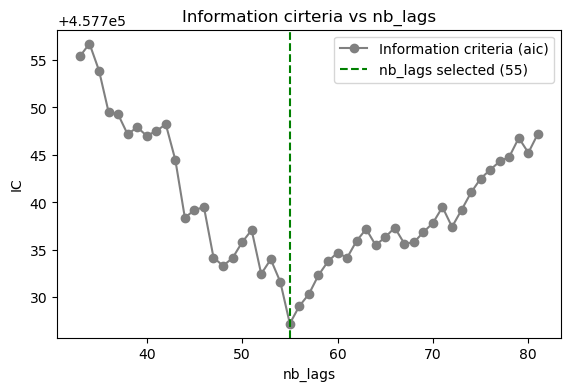

In [ ]:
def plot_ic_all_lags(y, max_lag: int | None = None, ic: Literal["aic", "bic", "hqic"] = "aic"):
    if (max_lag is None):
        # Schwert (1989)
        max_lag = int(np.ceil(12.0 * np.power(len(y) / 100.0, 1 / 4.0)))

    x, y = lagmat(y, max_lag, original="sep")
    x = sm.add_constant(x)
    y = y[max_lag:]
    x = x[max_lag:]
    x_pd = pd.DataFrame(x)

    ics = []
    ics_to_plot = []
    for i in range(max_lag + 1):
        x_selection = x_pd.values[:, slice(i + 1)]

        ols_model = linear_models.OLS(y, x_selection)
        ols_model.df_model = x_selection.shape[1] - 1
        ols_model.k_constant = 1

        res = ols_model.fit()
        
        lags = tuple(j for j in range(1, i + 1))
        lags = 0 if not lags else lags
        ics.append((lags, res.info_criteria(ic)))
        ics_to_plot.append(res.info_criteria(ic))
    
    selected_tuple = min(ics, key=lambda x: x[1])
    selected_lags = selected_tuple[0]
    nb_lags = len(selected_lags)

    skip_first_n_lags = 32
    nb_lags_to_plot = list(range(max(0, skip_first_n_lags + 1), max_lag + 1))
    if (nb_lags <= skip_first_n_lags):
        print(f"GREEN LINE WILL NOT BE SHOWN BECAUSE SELECTED NB_LAG ({nb_lags}) <= skip_first_n_lags ({skip_first_n_lags})")
    fig, axe = plt.subplots(1, 1, figsize=(6.5, 4))
    axe.plot(nb_lags_to_plot, ics_to_plot[skip_first_n_lags + 1:], color="grey", marker="o", label=f"Information criteria ({ic})")
    axe.axvline(x=nb_lags, color='green', label=f"nb_lags selected ({nb_lags})", linestyle='--')
    axe.set_title("Information cirteria vs nb_lags")
    axe.set_xlabel("nb_lags")
    axe.set_ylabel("IC")
    axe.legend()
    plt.show()
    return nb_lags

nb_lags = plot_ic_all_lags(signs)